# Why RMSProp is Such a Big Deal for Adaptive Learning Rates
-----------------------


In this article we're going to be discussing RMSProp – an equation which dynamically adjusts the learning rate for neural networks. It was first introduced by Geoffrey Hinton in [his Coursera course](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf), and, like much of Professor Hinton's work, has since been very influential in the world of deep learning. In terms of the equation, it looks very similar to the momentum equation (you can check out [my momentum article](https://cutt.ly/cg2ai-momentum-medium) in case you missed it), but the minor differences is what sets it apart.

Here’s the equation for momentum:<br/>
*constant(velocity) + (1-constant)(gradients)*

And here’s RMSProp's equation:<br/>
*constant(velocity) + (1-constant)(gradients^2)*

I wasn't lying when I said the equations look very similar. Both of them are their own flavors exponentially weighted average equations (please refer to [my momentum article](https://cutt.ly/cg2ai-momentum-medium) for further explanation for a further in-depth explanation of exponentially weighted average).

So what makes RMSProp so different? Why is it that we're using an almost identical equation, but giving it a different name and calling it potentially better? First, let's go over how the equation differs and then we can get into the implementation.

As you can see from above, the only difference between the 2 equations is that 1 squares the gradients (i.e., RMSProp) while the other (i.e., momentum) doesn't. What difference does that make?

Better than explaining with words, let's plug some numbers in and see what happens.

For this exercise, we'll randomly choose a number between 0 and 100 for each of the 5 iterations and keep adding it to the equation. It'll give us an understanding of how the 2 perform quite differently. We'll take the square root of the RMSProp equation as our output, because that's how it's used in its implementation (discussed further below).

In [1]:
import random

constant = 0.99
velocity_r = 0.
velocity_m = 0.

for i in range(5):
    gradient = random.randint(0, 100)
    velocity_r = constant*velocity_r + (1-constant)*(gradient**2) ##RMSProp eqn
    velocity_m = constant*velocity_m + (1-constant)*gradient ##momentum eqn
    print('gradient: {0} - rmsprop: {1:2f}; momentum: {2:2f}'.format(gradient, velocity_r**0.5, velocity_m))

gradient: 46 - rmsprop: 4.600000; momentum: 0.460000
gradient: 63 - rmsprop: 7.787066; momentum: 1.085400
gradient: 67 - rmsprop: 10.243145; momentum: 1.744546
gradient: 2 - rmsprop: 10.193763; momentum: 1.747101
gradient: 47 - rmsprop: 11.178715; momentum: 2.199630


Interesting. We see that although we may think squaring a number and then taking its square root would give the same result as not having it at all, we find that not to be true. Had that been true, then both the square root of the RMSProp and the momentum would give us the same results. Although squaring something and then taking the square root of it may seem redundant, the reality is that when we square something, multiply it by a decimal (0.01 in our case), and then take the square root of it, it has a weighted effect that doesn't happen in the momentum equation.

Secondly, something which we’re not showing in the example above is that squaring any number, including negative numbers, turns it into a positive number. This means that RMSProp treats negative gradients the same way it does positive gradients, whereas momentum makes a distinction between the two.

## RMSProp Implementation 

Now that we've gone over the equation, let's go over the implementation.

The following is the implementation of the RMSProp equation in the update step:<br/>
*(learning_rate/√RMSProp)(gradients)*

Unlike momentum, RMSProp doesn't take the place of the gradients, rather, the learning rate is divided by the square root of the RMSProp equation. This is a fundamental difference in the 2 algorithms. This difference is what makes the learning rate dynamic.

## Implementing RMSProp in Code

Now that we’ve covered the equation in detail, let’s see how we can implement RMSProp in code.

As always, in order to implement this in code, we're going to need a dataset. I'll be reusing the same random dataset which I've used for the past few articles. Because this is just for demonstration purposes, we don't need something very complex, but that also means that this dataset isn't to be taken as a benchmark, rather just a fun dataset which makes the explanation easy.

Let's begin by importing the relevant libraries, creating some mock data, and then putting our mock data into PyTorch's DataLoader class for ease of use.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dim = 1000
X = torch.randn((dim,dim), dtype=float)
y = torch.cat((torch.zeros(dim//2, dtype=float), torch.ones(dim//2, dtype=float)))

class ExampleDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.len = len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len


data = ExampleDataset(X, y)
data_loader = DataLoader(dataset=data, batch_size=64, shuffle=True)

Next, we'll create our neural network architecture. This architecture is something I often use for quick demonstration purposes. It's 1 hidden layer with half the size of the input layer.

In [3]:
class Model(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.hidden_layer = nn.Linear(dim, dim//2)
        self.last_layer = nn.Linear(dim//2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X):
        out = self.sigmoid(self.hidden_layer(X))
        out = self.sigmoid(self.last_layer(out))
        return out

Now, before we demonstrate RMSProp, we'll train our data on a vanilla SGD optimizer so that we can compare and see how RMSProp performs. We'll train our data for 1000 epochs with a learning rate of 1e-5. Also, to speed up our training, we're going to be using the GPU for this tutorial.

Note: to turn the GPU on in Google Colab, go to Edit > Notebook settings and then change the hardware settings to GPU (the GPU is free to use).

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 1000
learning_rate = 1e-5

model = Model(dim).to(device)
bce = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

epoch_loss = []
model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.69401
Train: epoch: 100 - loss: 0.69393
Train: epoch: 200 - loss: 0.69396
Train: epoch: 300 - loss: 0.69378
Train: epoch: 400 - loss: 0.69350
Train: epoch: 500 - loss: 0.69360
Train: epoch: 600 - loss: 0.69336
Train: epoch: 700 - loss: 0.69340
Train: epoch: 800 - loss: 0.69318
Train: epoch: 900 - loss: 0.69330
Train: epoch: 1000 - loss: 0.69293


Let's plot our loss to see how its shape looks throughout the epochs.

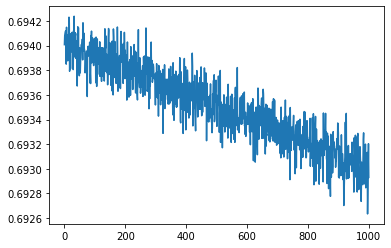

In [5]:
plt.plot(epoch_loss)

Now we'll train our model with RMSProp. Before we do that, we're going to rearrange the RMSProp equation for ease of implementation. Because replacing the learning rate (a decimal scalar) with a matrix is going to make our code fail (PyTorch establishes type restrictions for code stability), for the purposes of our demonstration, we're going to need to rearrange our equation. The PyTorch library overcomes this by creating a whole new class for RMSProp and not using the SGD optimizer for the RMSProp implementation, but to make do with what we have, we'll make a little tweak. Due to the nature of the equation (if you remember your high school math), instead of dividing the learning rate by the square root of the RMSProp equation, we'll divide the gradients by the square root of the RMSProp equation (this is the RMSProp equation which [Andrew Ng references in his videos](https://www.youtube.com/watch?v=_e-LFe_igno)) to achieve the same results.

To clear up any confusion, when rearranged, our equation now looks like this:<br/>
*(learning_rate)(gradients/√RMSProp)*

One thing I'm forgetting is the RMSProp constant. We'll create an rmsprop variable and set that to 0.99.

Let's get into it and implement RMSProp in code. We're going to be accessing the gradients in our optimizer. If you're uncertain as to how that's done, please refer to [my article on weight decay](https://cutt.ly/cg2ai-weight-decay-medium) where I detail the steps further there.

In [6]:
model = Model(dim).to(device)
bce = nn.BCELoss()
# we'll reuse the learning_rate variable from above
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
rmsprop = 0.99

epoch_loss = []
velocities = {}

model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        for name, w in model.named_parameters():
            if name not in velocities:
                velocities[name] = torch.zeros_like(w.grad).detach()
            velocities[name].mul_(rmsprop).add_(torch.square(w.grad).mul_(1-rmsprop))
            w.grad.divide_(torch.sqrt(velocities[name]))
        optimizer.step()

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.69655
Train: epoch: 100 - loss: 0.55193
Train: epoch: 200 - loss: 0.43985
Train: epoch: 300 - loss: 0.34813
Train: epoch: 400 - loss: 0.27447
Train: epoch: 500 - loss: 0.21446
Train: epoch: 600 - loss: 0.16343
Train: epoch: 700 - loss: 0.12122
Train: epoch: 800 - loss: 0.08637
Train: epoch: 900 - loss: 0.06013
Train: epoch: 1000 - loss: 0.03987


That seems to have performed really well. Let's see how it looks in graph form.

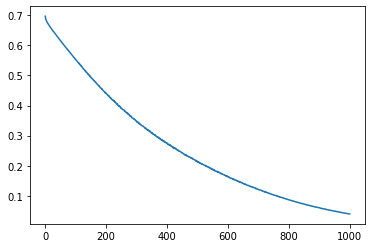

In [7]:
plt.plot(epoch_loss)

You can see that RMSProp really helps find a more optimal path to a better minimum. The idea of using an exponentially weighted average makes a very noticeable difference. To get a better understanding of the equation and how it expands, please refer to [my momentum article](https://cutt.ly/cg2ai-momentum-medium). In the article, I've explained how the equation rolls out in extensive detail. 

## Using RMSProp with PyTorch's API

As always, the good news is that PyTorch has already implemented RMSProp in their library, enabling us to use their simple API call, rather than having to code it up ourselves every time. They’ve implemented it in its original form, where they’re dividing the learning rate, rather than the gradients.

Let’s use PyTorch’s built-in RMSProp functionality and see how it performs relative to ours.

By the way, in PyTorch, our RMSProp constant is known as alpha. We'll use the rmsprop variable from above to set it.

In [8]:
model = Model(dim).to(device)
bce = nn.BCELoss()
# we'll reuse the learning_rate and rmsprop values from above
optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate, alpha = rmsprop)

epoch_loss = []
model.train()
for epoch in range(epochs+1):
    iteration_loss = 0.
    for i, data in enumerate(data_loader):
        X, y = data
        y_pred = model(X.float().to(device))
        loss = bce(y_pred.to(device), y.reshape(-1,1).float().to(device))
        iteration_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss.append(iteration_loss/(i+1))
    if(epoch % 100 == 0):
        print('Train: epoch: {0} - loss: {1:.5f}'.format(epoch, epoch_loss[-1]))

Train: epoch: 0 - loss: 0.70007
Train: epoch: 100 - loss: 0.56423
Train: epoch: 200 - loss: 0.45106
Train: epoch: 300 - loss: 0.35551
Train: epoch: 400 - loss: 0.28075
Train: epoch: 500 - loss: 0.22049
Train: epoch: 600 - loss: 0.16824
Train: epoch: 700 - loss: 0.12654
Train: epoch: 800 - loss: 0.09177
Train: epoch: 900 - loss: 0.06355
Train: epoch: 1000 - loss: 0.04242


So far so good. Let’s plot our results.

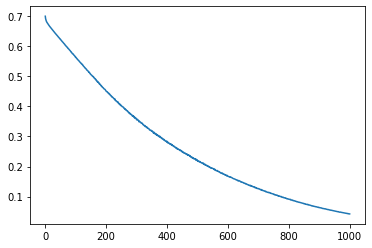

In [9]:
plt.plot(epoch_loss)

Awesome! Our manual implementation is essentially identical!

If you look through RMSProps _ _init_ _ function definition, you probably noticed an eps (epsilon) argument which is set to 1e-8 by default. This epsilon variable is for the purposes of numerical stability. What that means is that this epsilon is added to the square root of RMSProp so that, in the case that our RMSProp is ever 0, we don’t divide the learning rate by 0, because dividing by 0 will break our equation and therefore our code.

In case you’re curious, our equation with the epsilon looks like this:<br/>
*(learning_rate/(√RMSProp+epsilon))(gradients)*

## Choosing the right alpha
If you’ve taken a look at PyTorch’s RMSProps _ _init_ _ function definition, you probably realized that PyTorch has set a default value for alpha to 0.99. In practice, it’s agreed upon that 0.99 is the best value to keep and probably isn’t worth changing. You could try, but 0.99 works quite well. It’s best to put your efforts around finding the best learning rate, rather than playing around with the alpha or epsilon values.

And that concludes our tutorial on RMSProp and its implementation. Congratulations! You should now know how to implement RMSProp from scratch!